In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.special import logsumexp
from scipy.optimize import minimize

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from aeons.toy_samples import cauchy_samples
from aeons.lm_partial import analytic_lm_params, X_end_formula, analytic_lm, params_from_d
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG
from aeons.endpoint import EndModel

In [2]:
def add_logZ(samples):    
    logw = samples.logw()
    logZ = np.zeros_like(logw)
    logZ[0] = logw.iloc[0]
    for i in range(1, len(samples)):
        logZ[i] = logsumexp([logZ[i-1], logw.iloc[i]])
    samples['logZ'] = logZ
    return samples

def get_dlogZ(logZ):
    logZ = pd.Series(logZ)
    dlogZ = logZ.diff(1)[1:]
    return dlogZ

def get_dlogZ_rolling(dlogZ, N_rolling):
    dlogZ = pd.Series(dlogZ)
    dlogZ_rolling = dlogZ.rolling(N_rolling).mean()
    dlogZ_rolling.dropna(inplace=True)
    return dlogZ_rolling

import numpy.polynomial.polynomial as poly
def fit_dlogZ(dlogZ, deg):
    x = dlogZ.index.get_level_values(0).values
    y = dlogZ.values
    coefs = poly.polyfit(x, y, deg)
    return coefs

In [181]:
class IncrementEndpoint:
    def __init__(self, samples, N_rolling):
        self.samples = add_logZ(samples)
        self.logZ = self.samples['logZ']
        self.dlogZ = get_dlogZ(self.logZ)
        self.dlogZ_rolling = get_dlogZ_rolling(self.dlogZ, N_rolling)
        self.N_rolling = N_rolling
        self.rolling_index = self.dlogZ_rolling.index.get_level_values(0)
        self.true_endpoint = self.calc_endpoint() # using default value of 1e-3

    def plot_dlogZ(self):
        dlogZ = self.dlogZ
        plt.plot(dlogZ.index.get_level_values(0), dlogZ.values)

    def calc_endpoint(self, epsilon=1e-3):
        logZ = self.logZ
        logZ_tot = logZ.iloc[-1]
        logZ_f = np.log(1 - epsilon) + logZ_tot
        index_f = logZ[logZ > logZ_f].index.get_level_values(0)[0]
        return index_f

    def index(self, iteration):
        return self.dlogZ.iloc[iteration:].index.get_level_values(0).values
    
    def dlogZ_fit(self, iteration, N_fit):
        return self.dlogZ_rolling.iloc[iteration - N_fit - self.N_rolling : iteration - self.N_rolling]
    
    def pred(self, iteration, N_fit):
        index = np.arange(iteration - N_fit, len(self.samples))
        dlogZ_fit = self.dlogZ_fit(iteration, N_fit)
        coefs = fit_dlogZ(dlogZ_fit, 1)
        dlogZ_pred = poly.polyval(index, coefs)
        index_pred = index[dlogZ_pred > 0]
        dlogZ_pred = dlogZ_pred[dlogZ_pred > 0]
        return index_pred, dlogZ_pred

    def plot_pred(self, iteration, N_fit):
        index_pred, dlogZ_pred = self.pred(iteration, N_fit)
        dlogZ_rolling = self.dlogZ_rolling
        dlogZ_fit = self.dlogZ_fit(iteration, N_fit)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
        ax1.plot(dlogZ_rolling.index.get_level_values(0), dlogZ_rolling)
        ax1.plot(dlogZ_fit.index.get_level_values(0), dlogZ_fit, color='deepskyblue')
        ax1.plot(index_pred, dlogZ_pred, color='orange', lw=1)
        ax1.set_ylim(0, dlogZ_rolling.iloc[0])

        ax2.plot(dlogZ_rolling.index.get_level_values(0), dlogZ_rolling)
        ax2.plot(dlogZ_fit.index.get_level_values(0), dlogZ_fit, color='deepskyblue')
        ax2.plot(index_pred, dlogZ_pred, color='orange', lw=1)
        ax2.axvline(x = iteration, lw=.5, ls='--', color='deepskyblue')
        ax2.set_xlim(iteration - N_fit, len(self.samples))
        ax2.set_ylim(0, dlogZ_fit.values[0]*1.5)

    def iterations(self, iteration, N_fit, epsilon=1e-3):
        logZ_dead = self.logZ.loc[iteration]
        index_pred, dlogZ_pred = self.pred(iteration, N_fit)
        logZ_live = dlogZ_pred.sum()
        logZ_tot = logZ_dead + logZ_live
        logZ_f = np.log(1 - epsilon) + logZ_tot
        index_f = index_pred[np.argmax([logZ_dead + dlogZ_pred.cumsum() > logZ_f])]
        return logZ_dead, logZ_tot, index_f
    
    def predictions(self, N, N_fit):
        true_end = self.true_endpoint
        iterations = np.linspace(N_fit, true_end, N, endpoint=False).astype(int) # start at N_fit
        predictions = np.zeros(N)
        for i, iteration in enumerate(iterations):
            try:
                predictions[i] = self.iterations(iteration, N_fit)[-1]
            except:
                print(f'Iteration {iteration} invalid')
        return iterations, predictions
    
    def plot_predictions(self, N, N_fit):
        true_end = self.true_endpoint
        iterations, predictions = self.predictions(N, N_fit)
        plt.plot(iterations, predictions)
        plt.axhline(y=true_end, lw=1, ls='--')
        plt.ylim(0, true_end*1.5)
        return iterations, predictions

### Gaussian chain

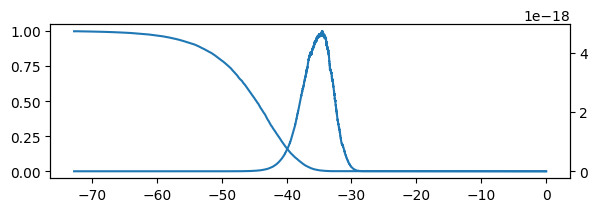

In [4]:
from aeons.toy_samples import gaussian_samples, correlated_gaussian_samples
nlive = 500
d, sigma = 10, 0.01
samples = gaussian_samples(nlive, d, sigma)
gauss = EndModel(samples)
gauss.plot_lx()

In [5]:
samples = gauss.samples
increment = IncrementEndpoint(samples, N_rolling=1000)
true_end = increment.true_endpoint()

In [6]:
iterations = np.linspace(100, 30000, 10).astype(int)
logXfs, logXfs_std = gauss.logXfs(iterations, Nset=10)

(0.0, 35000.0)

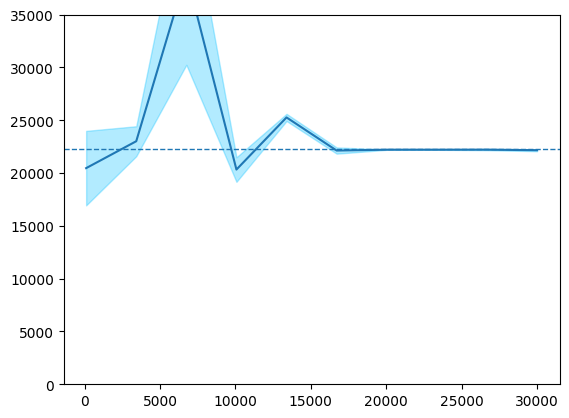

In [7]:
predictions, predictions_std = logXfs * -500, logXfs_std * -500
plt.plot(iterations, predictions)
plt.fill_between(iterations, predictions - predictions_std, predictions + predictions_std, color='deepskyblue', alpha=0.3)
plt.axhline(y=true_end, lw=1, ls='--')
plt.ylim(0, 35000)

(-2215.157704111345, -115.6168270895464, 6196)

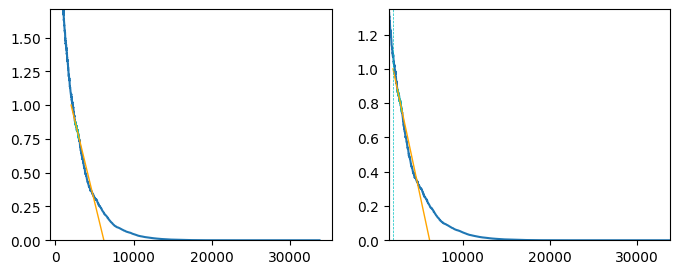

In [8]:
iteration = 2000
N_fit = 500
increment.plot_pred(iteration, N_fit)
increment.iterations(iteration, N_fit)

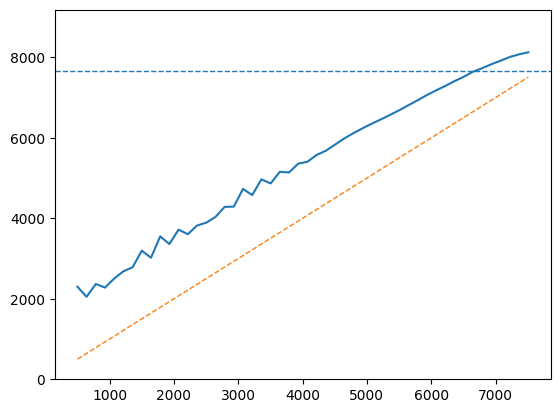

In [132]:
N = 50
iterations = np.linspace(N_fit, true_end, N, endpoint=False).astype(int)
predictions = np.zeros(N)
for i, iteration in enumerate(iterations):
    predictions[i] = increment.iterations(iteration, N_fit)[-1]
plt.plot(iterations, predictions)
plt.axhline(y=true_end, lw=1, ls='--')
plt.ylim(0, true_end*1.2)
plt.plot(iterations, iterations, lw=1, ls='--')

### Wedding cake chain

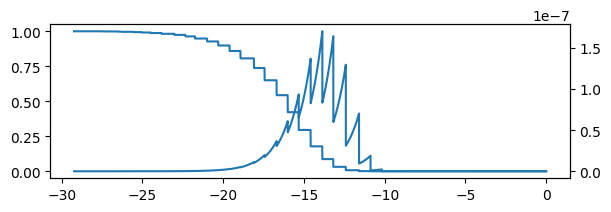

In [12]:
wedding = EndModel(samples_w_1)
wedding.plot_lx()

In [143]:
wedding_inc = IncrementEndpoint(samples_w_1, N_rolling=1000)
true_end = wedding_inc.true_endpoint
true_end

7652

(-116.51482011241532, 155.16355544329664, 2488)

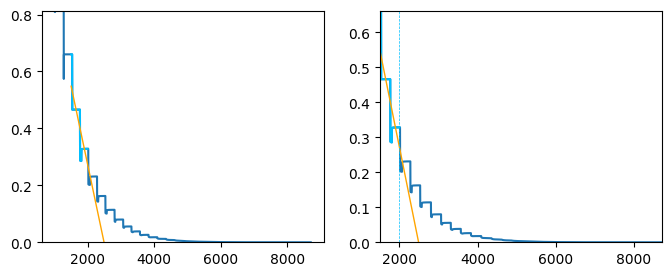

In [144]:
iteration = 2000
N_fit = 500
wedding_inc.plot_pred(iteration, N_fit)
wedding_inc.iterations(iteration, N_fit)

Iteration 1000 invalid
Iteration 1266 invalid
Iteration 1532 invalid
Iteration 1798 invalid


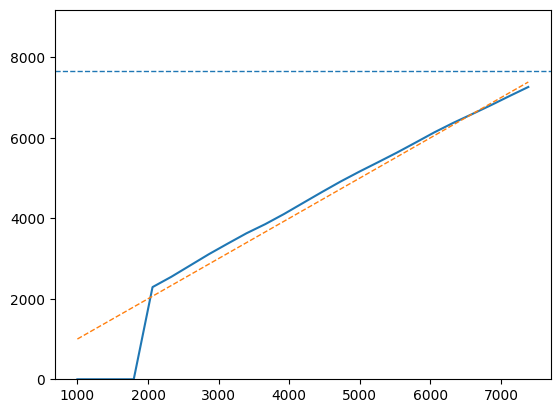

In [146]:
iterations, predictions = wedding_inc.plot_predictions(25, 1000)
plt.plot(iterations, iterations, lw=1, ls='--')

### Cauchy samples

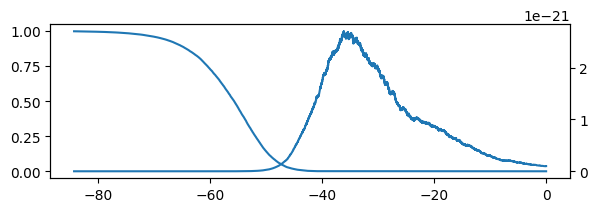

In [152]:
cauchy_chain = cauchy_samples(nlive=500, ndims=10, gamma=0.01)
cauchy = EndModel(cauchy_chain)
cauchy.plot_lx()

In [200]:
cauchy_inc = IncrementEndpoint(cauchy_chain, N_rolling=1000)
true_end = cauchy_inc.true_endpoint

Iteration 2000 invalid
Iteration 2114 invalid
Iteration 2228 invalid
Iteration 2342 invalid
Iteration 2456 invalid
Iteration 2571 invalid
Iteration 2685 invalid
Iteration 2799 invalid
Iteration 2913 invalid


(0.0, 50000.0)

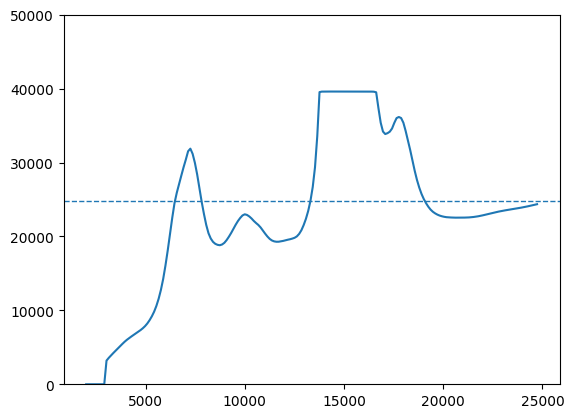

In [201]:
N_fit = 2000
cauchy_inc.plot_predictions(200, 2000);
plt.ylim(0, 50000)

39601

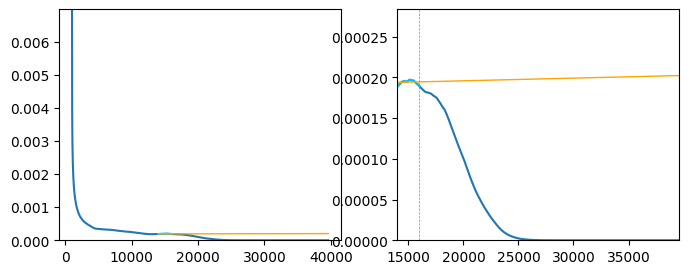

In [202]:
iterations = 16000
N_fit = 2000
cauchy_inc.plot_pred(iterations, N_fit)
cauchy_inc.iterations(iterations, N_fit)[-1]

### New chains

In [204]:
from anesthetic import read_chains

lbao = read_chains(root="../../lcdm/chains/lensing_BAO")

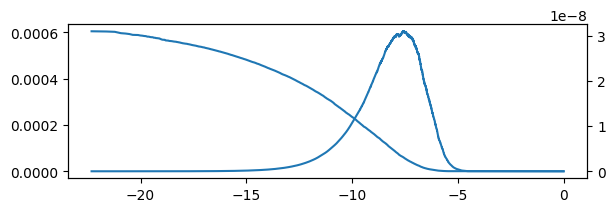

In [206]:
lbao_model = EndModel(lbao)
lbao_model.plot_lx()

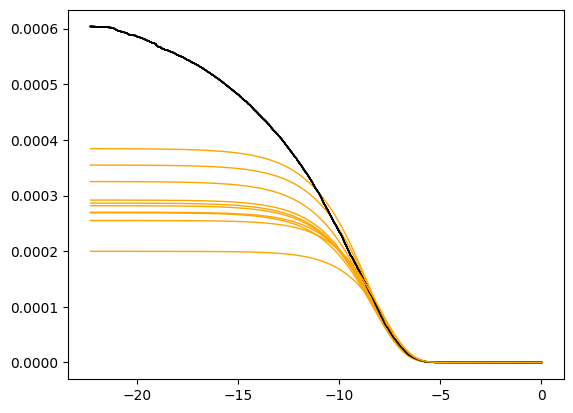

In [249]:
alphas = np.arange(0, 1, 0.1)
thetas = lbao_model.minimise(12000, Nset=10)
for theta in thetas:
    lbao_model.plot_theta(theta)

<Axes: xlabel='None'>

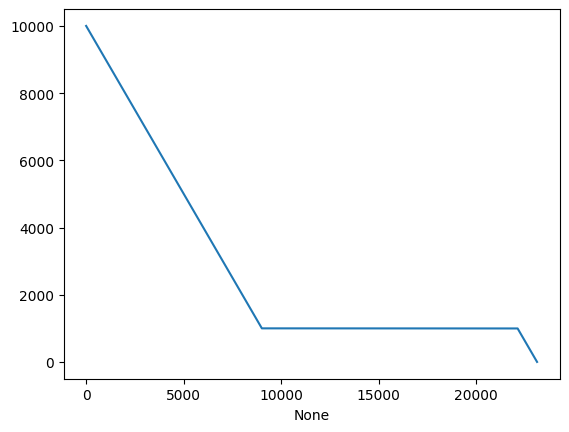

In [235]:
lbao.nlive.plot()

In [237]:
np.mean(lbao.nlive.values)

2730.99389900913

In [223]:
iterations = np.linspace(100, len(lbao), 10, endpoint=False).astype(int)
logXfs, logXfs_std = lbao_model.logXfs(iterations, Nset=10)

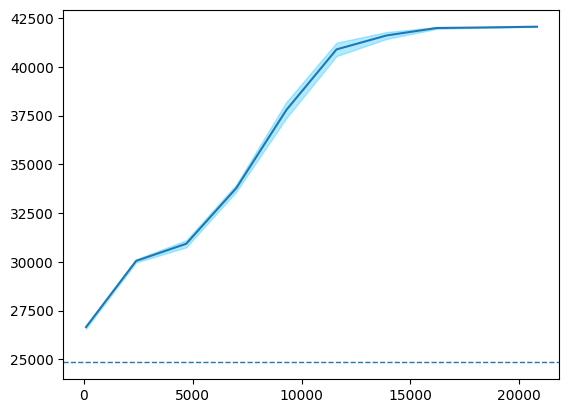

In [238]:
nlive = 2730
predictions, predictions_std = logXfs * -nlive, logXfs_std * -nlive
plt.plot(iterations, predictions)
plt.fill_between(iterations, predictions - predictions_std, predictions + predictions_std, color='deepskyblue', alpha=0.3)
plt.axhline(y=true_end, lw=1, ls='--')

In [221]:
lbao_increment = IncrementEndpoint(lbao, N_rolling=500)

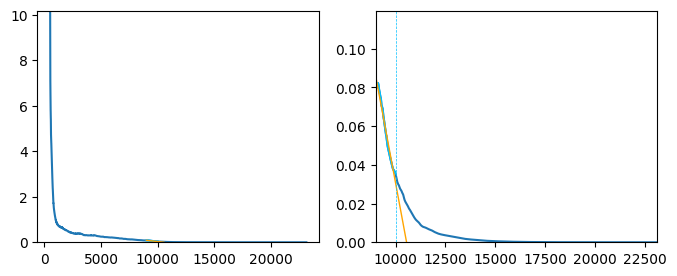

In [220]:
lbao_increment.plot_pred(iteration=10000, N_fit=1000)

Iteration 1000 invalid
Iteration 1422 invalid


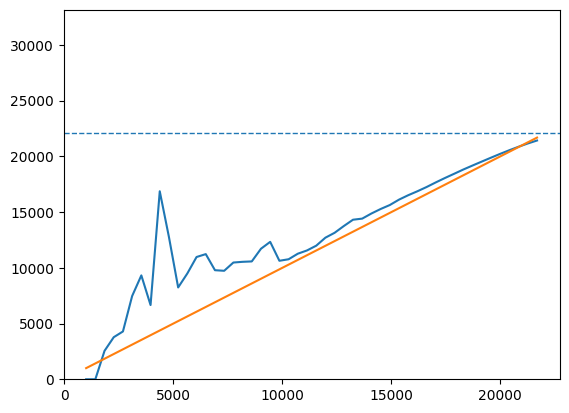

In [239]:
iterations = lbao_increment.plot_predictions(N=50, N_fit=1000)[0]
plt.plot(iterations, iterations)